# Offline DL Task
## MNIST Images Reconstruction through DCGAN's Framework Generator 


## Description

In this task, I implemented the convolutional generative model G and the binary classifier D as a part of the DCGAN framework. Both models are being trained on the MNIST dataset. The first part of the task is about training G, which learns to produce random images of digits from a latent space vector h sampled from a standard normal distribution. The main role of D is to get an image as an input and guess whether it came from the original dataset or the one synthesized by G. In simple words, G tries to trick D while D tries to reveal the truth. As such, both G and D contribute to each other's learning process. Trus, this type of learning is an unsupervised one that needs not original dataset labeling. Eventually, the goal is to train a high-quality G.

In the second part Encoder E performs MNIST images encoding into a latent space vector h_E. Then it feeds h_E to G. G, in its turn, has to output the image close to the input image of E. Since I didn't get the task right first, I created a simple Autoencoder model with E and decoder inside, trained both encoder and decoder. Once E was trained - I passed the MNIST image to E, which compressed it and transmited to G, which had to reconstruct the image very close to the original one. Of course, it didn't work, so now I trained autonomous Encoder on DCGAN's generator. I still left my first interpretation, since it holds a lot of useful comments and shows that encoder-decoder models trained independently cannot produce a meaningful result together.  

### Used Materials

Doing this task I was using the following sources:

- Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks paper:
  https://arxiv.org/pdf/1511.06434.pdf
- https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
- https://deeplizard.com/learn/video/lu7TCu7HeYc
- https://pytorch.org/vision/stable/index.html
- https://medium.com/@attyuttam/generative-adversarial-networks-using-pytorch-3ad31cc61ac8
- https://towardsdatascience.com/how-to-generate-images-using-autoencoders-acfbc6c3555e
- https://www.wouterbulten.nl/blog/tech/getting-started-with-generative-adversarial-networks/
- https://yashk2810.github.io/Applying-Convolutional-Neural-Network-on-the-MNIST-dataset/
- https://towardsdatascience.com/understanding-latent-space-in-machine-learning-de5a7c687d8d
- https://medium.com/the-theory-of-everything/understanding-activation-functions-in-neural-networks-9491262884e0
- https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53
- https://machinelearningmastery.com/batch-normalization-for-training-of-deep-neural-networks/
- https://nn.labml.ai/gan/dcgan.html
- https://www.cs.toronto.edu/~lczhang/360/lec/w05/autoencoder.html
- http://people.sabanciuniv.edu/berrin/cs512/lectures/naivebayes-good.pdf

The list is non-exhausive.

## Implementation

## Part 1

### Importing Libraries

In [1]:
import os
import random
import numpy as np
import torch
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
# the static images of the plot will be embedded in the notebook
%matplotlib inline 
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

#### Checking Python Version

I used at least one feature in this code inherent to python3 only. So I assume the code will be run on python3.

In [2]:
# checking python version, I assume the code will run on python3
import platform
print('python version: ', platform.python_version())

python version:  3.6.9


### Ensuring reproducibility

The below code sets fixed seeds for reproducibility that eases the development process, yet adds a bit of more computational load on the system.

In [3]:
fixed_seed = 26

random.seed(fixed_seed)              # setting the seed in python random number generator
torch.manual_seed(fixed_seed)        # setting the seed of pytorch random number generator
np.random.seed(fixed_seed)           # setting the seed of numpy random number generator
torch.backends.cudnn.enabled = False # disabling some nondeterministic algorithms cudnn uses

### Constants

In [1]:
batch_size  = 128          # batch_size from DCGAN paper
dataroot    = "./data"     # root directory for dataset to load into
modelroot   = "./model"    # root directory for storing model's state dictionaries
latent_size = 100          # number of channels in h latent vector, taken from DCGAN paper
ngf         = 256          # size of feature maps in generator; we can think of it as of a number of input channels in the last ConvTranspose2d layer
ndf         = 256          # size of feature maps in discriminaror; we can think of it as of a number of output channels in the first Conv2d layer
nc          = 1            # number of channels of the output image, mnist is a dataset of grayscale images, so we have 1 color channel here

### MNIST Dataset Loading

In [5]:
#Create data directory if does not exist
if not os.path.exists(dataroot):
    os.mkdir(dataroot)

In [9]:
# Loading and preprocessing images.

# ToTensor() converts obtained PIL.Image into torch.FloatTensor.
# Each pixel gets converted into a number depending on the pixel's brightness, where 0 is black, 255 is white.
# Afterwards each pixel is devided by 255 and thus is being placed into a range [0.0, 1.0].

# Normalize() converts an actual range of values into a standard range of values, in our case [-1.0, 1.0].
# It works by subtracting the mean from the actual value and dividing by the standard deviation.
# E.g. pixel with the minimal value 0 will be converted to -1 (0 - 0.5 / 0.5 = -1).

mnist = MNIST(root=dataroot,   # we won't need validation dataset in either parts of the task, so downloading train dataset only
              train=True, 
              download=True,
              transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]))

Processing...
Done!


### Dataset Review

#### Tensor overview

A small sanity check on the downloaded data.

In [9]:
image, label = mnist[0]
print('label: ', label)
print(image[:,15:20,15:20])
torch.min(image), torch.max(image)

label:  tensor(5)
tensor([[[ 0.4588,  0.9843,  0.9843,  0.1765, -0.7882],
         [-0.8745, -0.2706,  0.9765,  0.9843,  0.4667],
         [-1.0000, -1.0000,  0.9529,  0.9843,  0.9529],
         [ 0.0196,  0.4353,  0.9843,  0.9843,  0.6235],
         [ 0.9843,  0.9843,  0.9843,  0.9608,  0.4275]]])


(tensor(-1.), tensor(1.))

Above is a tensor representation of one of the mnist's images.
This should be an image of digit 5, which we can inference from the label.
The values in the range are also the ones expected.

#### Image overview

Now we will observe the same sample on the chart.

label: tensor(5)


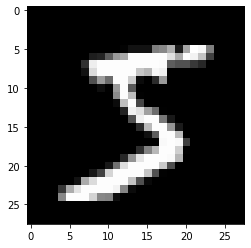

In [10]:
plt.imshow(image[0], cmap='gray')
print('label:', label)

We see 5 on the image, the very same digit we expected to see.

### Setting the Device for Model to Load on

Ideally, the computations from the task, especially the ones with DCGAN, should be performed from GPU, but I'm still listing both variants.

In [10]:
if torch.cuda.is_available():
    print("running on GPU")
    device = torch.device("cuda:0")
    num_gpu = 1
    workers = 8 # the number of worker threads for loading the data
else:
    print("running on CPU")
    device = torch.device("cpu")
    num_gpu = 0
    workers = 1

running on GPU


### Preparing the data for training with DataLoader

DataLoader is an iterable, that will come in handy when accessing the samples during the training. Our pre-loaded mnist dataset already arranged features and labels for us, although we won't use the latter. DataLoader in its turn wraps an iterable around the dataset and allows passing samples in batches of data. I will also set reshuffle so that the data will be reshuffled at every epoch, that is in most cases speeds up learning. 

In [11]:
dataloader = DataLoader(mnist, batch_size, shuffle=True, num_workers=workers) # passing dataset, num of images we want to see in a batch, shuffle, num of threads 

#### Data Overview in Dataloader

A small sanity check of the data wrapped by dataloader.

torch.Size([128, 1, 28, 28])


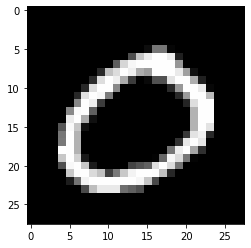

In [13]:
for images, labels in dataloader:
    print(images.shape)
    plt.imshow(images[0][0], cmap='gray')
    break

We see that we have 128 samples of 1 color channel, each 28x28 pixels.

### Weights Initialization

Weights and biases are the learnable parameters of the dataset. I will init those values, but the model will be tuning them accordingly during the training.
According to DCGAN paper "All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02", so I'm setting the same values: mean = 0.00, std = 0.02. In fact, weights_init function performs reinitialization in already initialized model for all the convolutional, convolutional-transpose, and batch normalization layers.

In [13]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02) # fills module weights with values drawn from the normal distribution
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)         # sets bias in BatchNorm layer to 0, that makes learning rate to become equal for each neuron, that speeds up overall learning

## Part 1. DCGAN Models
## h --> G --> x

### Generator

Generator G maps a latent space vector h to a data-space. While training it aims to asses the distribution forming real images and use this knowledge to create plausible fakes. The model tries to maximize the probability of cheating Descriminator D.

In [14]:
class Generator(nn.Module):               # Module is the base class that should be inhereted by all the neural network models
    def __init__(self):                   # costructor 
        super().__init__()                # calls the constructor of the parent class, in python 2 it would be written as super(Generator, self).__init__()
        self.main = nn.Sequential(
            # nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=1, padding=0, bias=True) input params that will be set
            # input is 1 x 1 latent space vector h with 100 channels
            nn.ConvTranspose2d(latent_size, ngf * 4, 3, 1, 0, bias=False), # fractionally-strided convolution, in DCGAN it is used instead of pooling layers in GAN
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # 3 x 3 layer with 1024 channels
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 3, 2, 0, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # 7 x 7 layer with 512 channels
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # 14 x 14 layer with 256 channels
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh() # converts all inputs into the (-1.0, 1.0) range
            # 28 x 28 layer with 1 channel
        )

    def forward(self, input):
        return self.main(input)

#### Generator instantiation

In [15]:
G = Generator().to(device) # load model instance to the device
G.apply(weights_init)      # will initialize the weights for every layer 
print(G)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)


### Discriminator

Discriminator will learn to differentiate between real and fake input images.

In [16]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            # input is a grayscale image 28 x 28
            # nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, bias=True) input params that will be set
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # 14 x 14 layer with 256 channels
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # 7 x 7 layer with 512 channels
            nn.Conv2d(ndf * 2, ndf * 4, 3, 2, 0, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # 3 x 3 layer with 1024 channels
            nn.Conv2d(ndf * 4, 1, 3, 1, 0, bias=False),
            nn.Sigmoid() # used to classify whether an input image is fake or real, returns a value in the rage [0; 1]
        )

    def forward(self, input):
        return self.main(input)

#### Discriminator instantiation

In [17]:
D = Discriminator().to(device)
D.apply(weights_init)
print(D)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(512, 1024, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (6): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(1024, 1, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (9): Sigmoid()
  )
)


### load model parameters instead of training if needed

In [18]:
G.load_state_dict(torch.load(os.path.join(modelroot, 'g_state_dict.pt')))
G.eval()

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)

In [19]:
D.load_state_dict(torch.load(os.path.join(modelroot, 'd_state_dict.pt')))
D.eval()

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(512, 1024, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (6): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(1024, 1, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (9): Sigmoid()
  )
)

### Loss Functions and Optimizers

Loss functions shows us how well the model performed. Then optimization algorithm is using this data to tune the learnable parameters in order to minimize the divergence.

In [20]:
criterion = nn.BCELoss() # Since we are working with binary classifier (discriminator will tell us whether the image is real or fake), Binary Cross Entropy loss function is used.

# Creating a batch of latent vectors drawn from the normal distribution that will be used to visualize the progress of the generator
num_of_fixed_h = 10
fixed_h = torch.randn(num_of_fixed_h, latent_size, 1, 1, device=device) # will return a tensor filled with random numbers with mean 0.0 and std 1.0

beta1 = 0.5 # coefficient used in Adam optimizer for computing running averages of gradient and its square (default: (0.9, 0.999)); DCGAN papaer sets 1st coef. to 0.5
lr = 0.0002 # learning rate for training, DCGAN sets 0.0002

# Adam optimization
optimizer_G = optim.Adam(G.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D = optim.Adam(D.parameters(), lr=lr, betas=(beta1, 0.999))

### Training

Put D and G into training mode. Batchnorm layer (and Dropout if I had used it) will get enabled.

In [20]:
D.train()

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(512, 1024, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (6): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(1024, 1, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (9): Sigmoid()
  )
)

In [21]:
G.train()

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)

In [24]:
real_label = 1. # label values for calculating losses for G and D
fake_label = 0.
num_epochs = 20 # num times the learning algorithm will work through the entire training dataset

# Lists to keep track of progress
images_generated = []
G_losses = []
D_losses = []

for epoch in range(num_epochs):
    loss_D_sum = 0.
    loss_G_sum = 0.
    D_x_sum = 0.
    D_G_h0_sum = 0.
    D_G_h1_sum = 0.
    for i, data in enumerate(dataloader, 0):
        # ***** Train D: Maximize log(D(x)) + log(1 - D(G(h))) ***** #
        
        # 1. Train with a real-image batch
        
        images, _ = data               # underscore means we will ignore the label from dataset, since we don't need it
        D.zero_grad()                  # zeroing out the gradients, so that parameter updates were done correctly. PyTorch accumulates the gradients on subsequent backward passes
        real_batch = images.to(device) # loading tensor to device's memory, real_batch is a copy of loaded batch
        b_size = real_batch.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device) # Creating a tensor with real labels of the same dimensions as a tensor with data
        output = D(real_batch).view(-1)        # Forward pass a real-image batch through D        
        loss_D_real = criterion(output, label) # Calculate the loss log(D(x))
        loss_D_real.backward()                 # Calculate gradients for D in backward pass
        D_x = output.mean().item()             # get the mean from the output distribution, or an average decision of the D concernign real images 
        D_x_sum += D_x                         # I will sum mean's from each iteration to calculate the mean of the each epoch 

        # 2. Train with fake-image batch
        
        batch_h = torch.randn(b_size, latent_size, 1, 1, device=device) # Generate batch of latent space vectors
        fake_batch = G(batch_h)                                         # Generate a fake-image batch with G
        label.fill_(fake_label)                                         # fill already used label tensor label with fake_label constants
        output = D(fake_batch.detach()).view(-1) # Forward pass a fake-image batch through D
                                                 # detach() detaches the output from the computationnal graph, not sure why we need it though       
        loss_D_fake = criterion(output, label)   # Calculate the loss log(1 - D(G(h)))
        loss_D_fake.backward()                   # Calculate the gradients for this batch, accumulated with previous gradients
        D_G_h0 = output.mean().item()
        D_G_h0_sum += D_G_h0
        loss_D = loss_D_real + loss_D_fake
        loss_D_sum += loss_D.item()
        optimizer_D.step()                       # adjust parameters in D with Adam optimizer 

        # ***** Train G: Maximize log(D(G(h))) ***** #
        
        G.zero_grad()
        label.fill_(real_label)                  # for G fake labels are real, meaning G's desired outcome is to have fake images defined as real by D
        output = D(fake_batch).view(-1)          # One more forward pass a fake-image batch through D after calling an optimizer on D
        loss_G = criterion(output, label)        # Calculate the loss log(D(G(h)))
        loss_G.backward()                        # Calculate gradients for G in backward pass
        loss_G_sum += loss_G.item()
        D_G_h1 = output.mean().item()
        D_G_h1_sum += D_G_h1
        optimizer_G.step()

        # ***** Print Statistics ***** #
        
        if i == len(dataloader) - 1:
            loss_D_float = loss_D_sum / len(dataloader)
            loss_G_float = loss_G_sum / len(dataloader)
            D_x = D_x_sum / len(dataloader)
            D_G_h0 = D_G_h0_sum / len(dataloader)
            D_G_h1 = D_G_h1_sum / len(dataloader)

            print("epoch: [{}/{}];\tloss_D: {:.4f};\tloss_G = {:.4f};\tD(x) = {:.4f};\tD(G(h0)) = {:.4f};\tD(G(h1)) = {:.4f}".format(
                epoch + 1, num_epochs, loss_D_float, loss_G_float, D_x, D_G_h0, D_G_h1))
        
        # ***** Save Generated Images ***** #
        # save the generated images at the very first iter, at the last iter of 1st epoch and then the last iter of every 2nd epoch end of each epoch to further see the progress
        
        if (i == 0 and epoch == 0) or (i == len(dataloader) - 1 and epoch % 5 == 0):
            with torch.no_grad():   # disable gradient calculation for this block, it will reduce memory consumption and increase computational speed, it's used for validation steps
                images_generated_fixed_h = G(fixed_h).detach().cpu()
            images_generated.append(images_generated_fixed_h)
            
        # Save Losses to depict them on graph after training
        G_losses.append(loss_G.item())
        D_losses.append(loss_D.item())

epoch: [1/20];	loss_D: 0.7376;	loss_G = 2.1469;	D(x) = 0.7467;	D(G(h0)) = 0.2523;	D(G(h1)) = 0.1977
epoch: [2/20];	loss_D: 0.7661;	loss_G = 2.1376;	D(x) = 0.7347;	D(G(h0)) = 0.2644;	D(G(h1)) = 0.2037
epoch: [3/20];	loss_D: 0.7983;	loss_G = 2.1228;	D(x) = 0.7273;	D(G(h0)) = 0.2717;	D(G(h1)) = 0.2075
epoch: [4/20];	loss_D: 0.7892;	loss_G = 2.1478;	D(x) = 0.7295;	D(G(h0)) = 0.2695;	D(G(h1)) = 0.2046
epoch: [5/20];	loss_D: 0.8073;	loss_G = 2.1503;	D(x) = 0.7269;	D(G(h0)) = 0.2722;	D(G(h1)) = 0.2052
epoch: [6/20];	loss_D: 0.7324;	loss_G = 2.2805;	D(x) = 0.7455;	D(G(h0)) = 0.2531;	D(G(h1)) = 0.1876
epoch: [7/20];	loss_D: 0.7870;	loss_G = 2.2648;	D(x) = 0.7383;	D(G(h0)) = 0.2609;	D(G(h1)) = 0.1919
epoch: [8/20];	loss_D: 0.7240;	loss_G = 2.3298;	D(x) = 0.7485;	D(G(h0)) = 0.2505;	D(G(h1)) = 0.1837
epoch: [9/20];	loss_D: 0.7506;	loss_G = 2.3259;	D(x) = 0.7456;	D(G(h0)) = 0.2537;	D(G(h1)) = 0.1858
epoch: [10/20];	loss_D: 0.7257;	loss_G = 2.3716;	D(x) = 0.7521;	D(G(h0)) = 0.2464;	D(G(h1)) = 0.1794

### Stop D and G Learning Process

This command will put all the layers into eval mode, in specific batch normalization will be deactivated.

In [25]:
D.eval()

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(512, 1024, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (6): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(1024, 1, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (9): Sigmoid()
  )
)

In [26]:
G.eval()

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)

### View Statistics

View G and D's losses.

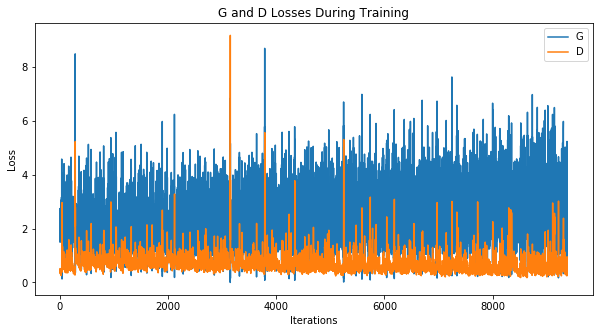

In [27]:
plt.figure(figsize=(10,5))
plt.title("G and D Losses During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

### View Generated Images

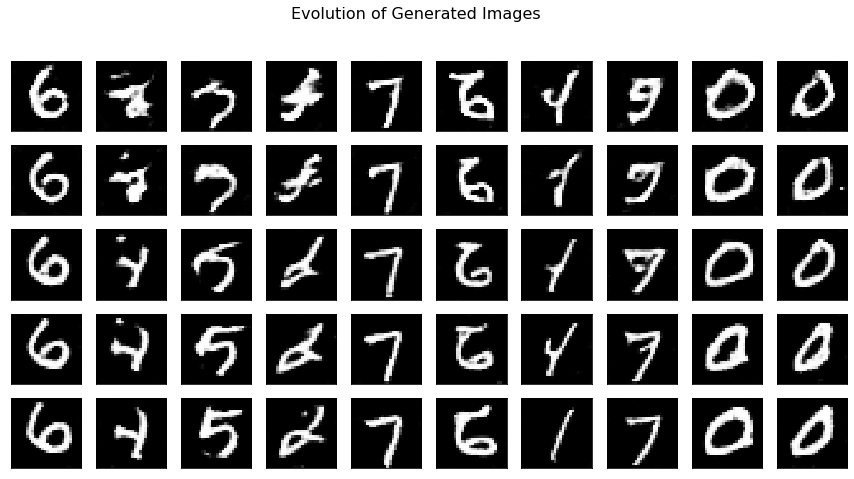

In [33]:
rows    = len(images_generated)
columns = num_of_fixed_h

fig = plt.figure(figsize=(1.5 * columns, 1.5 * rows))
fig.suptitle("Evolution of Generated Images", fontsize=16)

for r in range(rows):
    for c in range(columns):
        ax = plt.subplot(rows, columns, (c + 1) + (columns * r))
        plt.imshow(images_generated[r][c].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
plt.show()

The model has obviously evolved from the first iteration. Some 10 more iterations won't hurt though. 

### Save the models' state dictionaries

In [34]:
if not os.path.exists(modelroot):
     os.mkdir(modelroot)

f = open(os.path.join(modelroot, 'g_state_dict.pt'), mode="wb")
torch.save(G.state_dict(), f)
f.close()
f = open(os.path.join(modelroot, 'd_state_dict.pt'), mode="wb")
torch.save(D.state_dict(), f)
f.close()

## Part 2.0. Feed-Forward Autoencoder

I didn't got the task right from the very beggining. I thought I must have trained autoencoder and then use its encoder to work with DCGAN's generator. It didn't work eventually, but I will still leave it here. You can proceed to Part 2.1 directly.

#### Creating Autoencoder for obtaining Encoder E

A simple neural network, that produces the same output as its input. Encoder obtains flattened image vector, that is an image converted to a one dimensional vector, and compresses the image into a latent space vector. Decoder obtains encoder's output as its input and tries to reconstruct the image. For the task in Part 2. I need encoder E only, but I'm creating the whole model for E to be able to learn with decoder. 

In [33]:
flattened_image_size = 28 * 28

class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(flattened_image_size, 512),
            nn.ReLU(True),
            nn.Linear(512, 256),
            nn.ReLU(True),
            nn.Linear(256, 128),
            nn.ReLU(True),
            nn.Linear(128, latent_size)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, 128),
            nn.ReLU(True),
            nn.Linear(128, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, flattened_image_size),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [34]:
A = Autoencoder().to(device)
print(A)

criterion = nn.MSELoss()
optimizer_A = optim.Adam(A.parameters(), lr=lr, betas=(beta1, 0.999))

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=128, out_features=100, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=256, out_features=512, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=512, out_features=784, bias=True)
  )
)


### load model parameters instead of training if needed

In [35]:
A.load_state_dict(torch.load(os.path.join(modelroot, 'a_state_dict.pt')))
A.eval()

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=128, out_features=100, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=256, out_features=512, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=512, out_features=784, bias=True)
  )
)

### Autoencoder Training

In [37]:
A.train()

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=128, out_features=100, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=256, out_features=512, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=512, out_features=784, bias=True)
  )
)

In [39]:
A_losses = []
num_epochs = 60

for epoch in range(num_epochs):
    loss_A_sum = 0.
    for i, data in enumerate(dataloader, 0):
        images, _ = data
        images = images.to(device)
        images = images.view(images.size(0), -1)
        optimizer_A.zero_grad()
        output = A(images)
        loss_A = criterion(output, images)
        loss_A.backward()
        optimizer_A.step()
        loss_A_sum += loss_A.item()
        
        # ***** Update Statistics ***** #
        
        if i == len(dataloader) - 1:
            loss_A_float = loss_A_sum / len(dataloader)
            print("epoch: [{}/{}];\tloss_A: {:.4f}".format(epoch + 1, num_epochs, loss_A.item()))

        # Save training statistics
        A_losses.append(loss_A.item())

images_decoded = output.detach().cpu()

epoch: [1/60];	loss_A: 0.0296
epoch: [2/60];	loss_A: 0.0324
epoch: [3/60];	loss_A: 0.0280
epoch: [4/60];	loss_A: 0.0286
epoch: [5/60];	loss_A: 0.0268
epoch: [6/60];	loss_A: 0.0289
epoch: [7/60];	loss_A: 0.0332
epoch: [8/60];	loss_A: 0.0323
epoch: [9/60];	loss_A: 0.0272
epoch: [10/60];	loss_A: 0.0276
epoch: [11/60];	loss_A: 0.0278
epoch: [12/60];	loss_A: 0.0278
epoch: [13/60];	loss_A: 0.0279
epoch: [14/60];	loss_A: 0.0273
epoch: [15/60];	loss_A: 0.0298
epoch: [16/60];	loss_A: 0.0294
epoch: [17/60];	loss_A: 0.0278
epoch: [18/60];	loss_A: 0.0251
epoch: [19/60];	loss_A: 0.0259
epoch: [20/60];	loss_A: 0.0295
epoch: [21/60];	loss_A: 0.0266
epoch: [22/60];	loss_A: 0.0275
epoch: [23/60];	loss_A: 0.0257
epoch: [24/60];	loss_A: 0.0252
epoch: [25/60];	loss_A: 0.0263
epoch: [26/60];	loss_A: 0.0264
epoch: [27/60];	loss_A: 0.0266
epoch: [28/60];	loss_A: 0.0258
epoch: [29/60];	loss_A: 0.0260
epoch: [30/60];	loss_A: 0.0248
epoch: [31/60];	loss_A: 0.0253
epoch: [32/60];	loss_A: 0.0284
epoch: [33/60];	l

### Stop the Learning Process

In [40]:
A.eval()

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=128, out_features=100, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=256, out_features=512, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=512, out_features=784, bias=True)
  )
)

### View Statistics

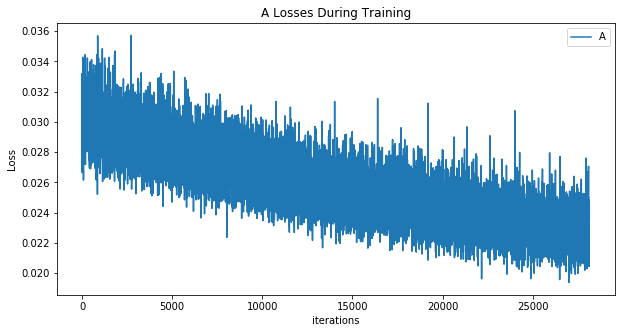

In [41]:
plt.figure(figsize=(10,5))
plt.title("A Losses During Training")
plt.plot(A_losses, label="A")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

### View Original VS Reconstructed Images

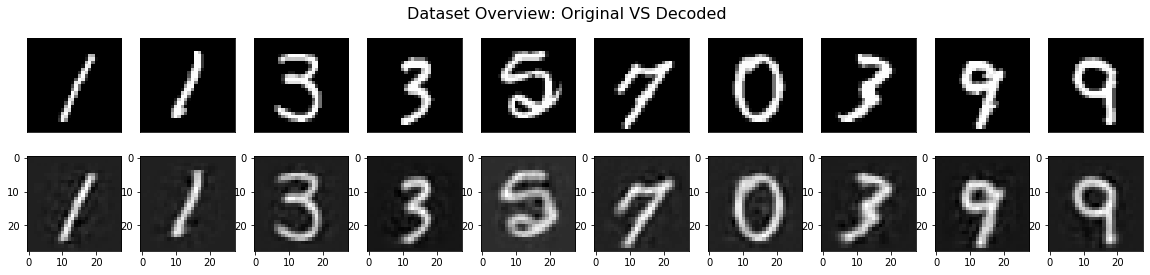

In [42]:
columns = 10

fig = plt.figure(figsize=(20, 4))
fig.suptitle("Dataset Overview: Original VS Decoded", fontsize=16)
for i in range(columns):
    #original dataset samples
    ax = plt.subplot(2, columns, i + 1)             # rows, columns, index
    plt.imshow(images[i].cpu().data.reshape(28,28)) # original dataset samples from the last iteration
                                                    #cpu() moves tensor from GPU to CPU memory, but since I don't do any assignment - it's just a copy.
                                                    # reshape() is a numpy method that cannot work on cuda tensor
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    plt.subplot(2, columns, i + columns + 1)
    plt.imshow(images_decoded[i].reshape(28, 28))   #decoded dataset samples
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

They definitely look alike :)

### Save the model's state dictionaries

In [43]:
if not os.path.exists(modelroot):
     os.mkdir(modelroot)

f = open(os.path.join(modelroot, 'a_state_dict.pt'), mode="wb")
torch.save(A.state_dict(), f)
f.close()

#### E trained on Autoencoder's decoder. E --> h_E --> G

Lets encode a batch of images through E and feed them to G.

In [64]:
random_images, _ = next(iter(dataloader))
random_images    = random_images[:10].to(device)
random_images    = random_images.view(random_images.size(0), -1)

h_E              = A.encoder(random_images)
h_E = h_E.view(h_E.size(0), -1, fixed_h.size(2), fixed_h.size(3))
h_E_to_G_output = G(h_E).detach().cpu()

#### View Original VS Decoded Image

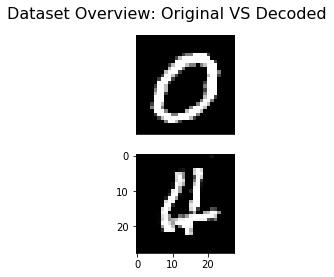

In [68]:
n = 1
fig = plt.figure(figsize=(20, 4))
fig.suptitle("Dataset Overview: Original VS Decoded", fontsize=16)
for i in range(n):
    #original dataset samples
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(random_images[0].cpu().data.reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    #decoded dataset samples
    plt.subplot(2, n, i + n + 1)
    plt.imshow(h_E_to_G_output[0].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

It didn't work. So I need to train encoder on a fixed generator, before trying to get an expected result of their common work.

## Part 2.1. Autonomous Encoder. Encoder Training on DCGAN's Generator

I will train E only here, while G is a fixed generator, that will be involved in E's learning process.

In [21]:
flattened_image_size = 28 * 28

class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Linear(flattened_image_size, 512),
            nn.ReLU(True),
            nn.Linear(512, 256),
            nn.ReLU(True),
            nn.Linear(256, 128),
            nn.ReLU(True),
            nn.Linear(128, latent_size)
        )

    def forward(self, input):
        return self.main(input)

In [23]:
E = Encoder().to(device)
print(E)

criterion = nn.MSELoss()
optimizer_E = optim.Adam(E.parameters(), lr=lr, betas=(beta1, 0.999))

Encoder(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=128, out_features=100, bias=True)
  )
)


### load model parameters instead of training if needed

In [ ]:
A.load_state_dict(torch.load(os.path.join(modelroot, 'e_state_dict.pt')))
A.eval()

### Encoder E Training

In [24]:
E.train()

Encoder(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=128, out_features=100, bias=True)
  )
)

In [48]:
E_losses = []
num_epochs = 10

for epoch in range(num_epochs):
    loss_E_sum = 0.
    for i, data in enumerate(dataloader, 0):
        images, _ = data
        images = images.to(device)
        images = images.view(images.size(0), -1)
        optimizer_E.zero_grad()
        h_E = E(images)                                                                  # get a latent space vector
        h_E = h_E.view(h_E.size(0), -1, fixed_h.size(2), fixed_h.size(3))                # G takes a 4 dim tensor as an input
        generated_images = G(h_E)                                                        # generate images
        generated_images = generated_images.cpu().reshape(generated_images.size(0), -1)  # flatten the image from 4 to 2 dims
        generated_images = generated_images.to(device)
        loss_E = criterion(generated_images, images)
        loss_E.backward()
        optimizer_E.step()
        loss_E_sum += loss_E.item()
        
        # ***** Update Statistics ***** #
        
        if i == len(dataloader) - 1:
            loss_E_float = loss_E_sum / len(dataloader)
            print("epoch: [{}/{}];\tloss_E: {:.4f}".format(epoch + 1, num_epochs, loss_E.item()))

        # Save training statistics
        E_losses.append(loss_E.item())

images_decoded = generated_images.detach().cpu()

epoch: [1/10];	loss_E: 0.0700
epoch: [2/10];	loss_E: 0.0658
epoch: [3/10];	loss_E: 0.0656
epoch: [4/10];	loss_E: 0.0589
epoch: [5/10];	loss_E: 0.0602
epoch: [6/10];	loss_E: 0.0580
epoch: [7/10];	loss_E: 0.0541
epoch: [8/10];	loss_E: 0.0487
epoch: [9/10];	loss_E: 0.0468
epoch: [10/10];	loss_E: 0.0476


### Stop the Learning Process

In [52]:
E.eval()

Encoder(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=128, out_features=100, bias=True)
  )
)

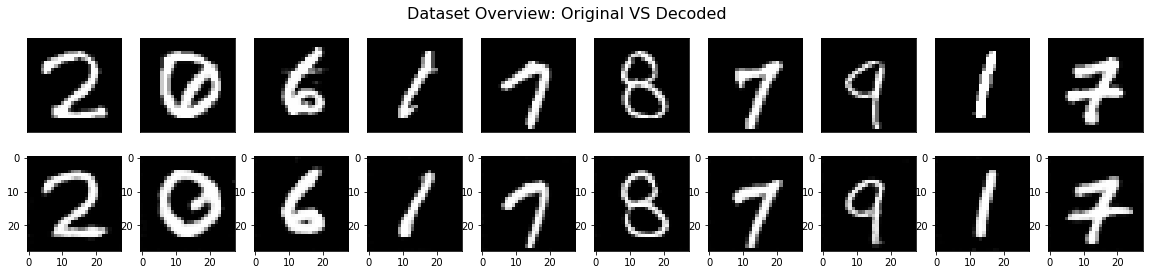

In [49]:
columns = 10

images_decoded = generated_images.detach().cpu()
fig = plt.figure(figsize=(20, 4))
fig.suptitle("Dataset Overview: Original VS Decoded", fontsize=16)
for i in range(columns):
    #original dataset samples
    ax = plt.subplot(2, columns, i + 1)             # rows, columns, index
    plt.imshow(images[i].cpu().data.reshape(28,28)) # original dataset samples from the last iteration
                                                    #cpu() moves tensor from GPU to CPU memory, but since I don't do any assignment - it's just a copy.
                                                    # reshape() is a numpy method that cannot work on cuda tensor
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    plt.subplot(2, columns, i + columns + 1)
    plt.imshow(images_decoded[i].reshape(28, 28))   #decoded dataset samples
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

This time encoded/decoded images look much better. I wouldn't even say which one is a fake.

### View Statistics

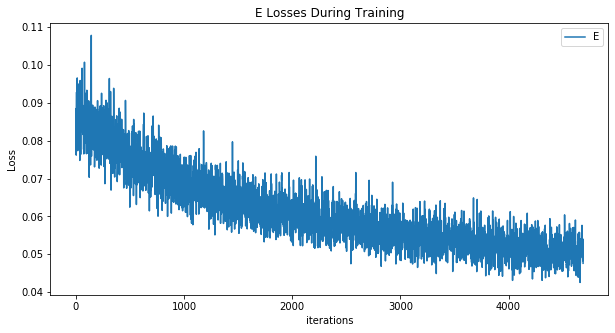

In [57]:
plt.figure(figsize=(10,5))
plt.title("E Losses During Training")
plt.plot(E_losses, label="E")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Save the models' state dictionaries

In [54]:
if not os.path.exists(modelroot):
     os.mkdir(modelroot)

f = open(os.path.join(modelroot, 'e_state_dict.pt'), mode="wb")
torch.save(G.state_dict(), f)
f.close()

### Clear the Memory

In [ ]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)